# Model Evaluation and Selection

## Load Libreries

In [36]:
# Librerias base
import os
import re
import json
from joblib import load
import warnings

# Manipulacion de datos
import pandas as pd
import numpy as np

# Visualizacion
import matplotlib.pyplot as plt
import seaborn as sns
# from IPython.display import clear_output
import collections
from pprint import pprint
%matplotlib inline

# Pipeline
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Modelamiento
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
# import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
# import shap

# Metricas
from sklearn.metrics import confusion_matrix, f1_score, fbeta_score, recall_score, precision_score, roc_auc_score, roc_curve

pd.options.display.max_columns = None
warnings.filterwarnings('ignore')


FILE_PATH = f'../data/models'

## Auxiliary Functions

In [97]:
def roc_plot(train, test, x_thres=None, y_thres=None, fig_title=None):
    """ Function for plotting roc curve
    """
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))
    fig.suptitle(f"ROC Curve - {fig_title} ", fontsize=20)
    axs[0].plot(train.fpr, train.tpr)
    axs[0].set_title("Training Data", fontdict={'fontname': 'Arial', 'fontsize': 18})
    axs[0].plot([0, 1], [0, 1], 'k--')
    axs[0].set_xlabel('False Positive Rate', fontdict={'fontname': 'Arial', 'fontsize': 18})
    axs[0].set_ylabel('True Positive Rate', fontdict={'fontname': 'Arial', 'fontsize': 18})
    axs[0].set_xticklabels(axs[0].get_xticklabels(), fontdict={'fontname': 'Arial',
                                                               'fontsize': 16})
    axs[0].set_yticklabels(axs[0].get_yticklabels(), fontdict={'fontname': 'Arial',
                                                               'fontsize': 16})
    axs[1].plot(test.fpr, test.tpr, color='orange')
    axs[1].set_title("Test Data", fontdict={'fontname': 'Arial', 'fontsize': 18})
    axs[1].plot([0, 1], [0, 1], 'k--')
    axs[1].scatter(x_thres, y_thres, color='red')
    axs[1].set_xlabel('False Positive Rate', fontdict={'fontname': 'Arial', 'fontsize': 18})
    axs[1].set_ylabel('True Positive Rate', fontdict={'fontname': 'Arial', 'fontsize': 18})
    axs[1].set_xticklabels(axs[1].get_xticklabels(), fontdict={'fontname': 'Arial',
                                                               'fontsize': 16})
    axs[1].set_yticklabels(axs[1].get_yticklabels(), fontdict={'fontname': 'Arial',
                                                               'fontsize': 16})
    plt.show()
    
    
def fpr_tpr_plot(data, title=None, x_thres=None, y_thres=None):
    df = data.loc[data.threshold <= 1, :].copy()
    fig, ax = plt.subplots(figsize=(7, 5))
    ax.scatter(df.threshold,np.abs(df.fpr + df.tpr - 1)) 
    ax.scatter(x_thres, y_thres, color='red')
    ax.set_xlabel("Threshold")
    ax.set_ylabel("|FPR + TPR - 1|")
    ax.set_title(f"FPR - TPR Curve- {title}")
    plt.show()
    
    
def precision_recall_plot(train, test, x_thres=None, y_thres=None, fig_title=None):
    """Function for plotting precision - recall plot
    """
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))
    fig.suptitle(f"Precision-Recall Curve - {fig_title}")
    axs[0].plot(train.recall, train.precision)
    axs[0].set_title("Training Data")
    # axs[0].plot([0, 1], [0, 1], 'k--')
    axs[0].set_xlabel('Recall')
    axs[0].set_ylabel('Precision')
    axs[1].plot(test.recall, test.precision, color='orange')
    axs[1].set_title("Test Data")
    axs[1].scatter(x_thres, y_thres, color='red')
    # axs[1].plot([0, 1], [0, 1], 'k--')
    axs[1].set_xlabel('Recall')
    axs[1].set_ylabel('Precision')
    plt.show()
    

def fscore_approve_plot(prec_rec_data, pred_data, beta=None, 
                        base_thres=None, alt_thres=None, fig_title=None):
    """ Function for plotting Fbeta-score and approval curve
    """
    approved = []
    reject = []
    for p in prec_rec_data.threshold:
        y_test_preds = []
        for prob in pred_data.predicted_bad:
            if prob > p:
                y_test_preds.append(1)
            else:
                y_test_preds.append(0)
                
        # Rechazados
        reject.append(np.mean(y_test_preds))
        # Aprobados
        approved.append(1 - np.mean(y_test_preds))

    beta = 2 if beta is None else beta
    fscore = ((1 + beta**2) * prec_rec_data.precision * prec_rec_data.recall) / (beta**2 * prec_rec_data.precision + prec_rec_data.recall)
    index = np.argmax(fscore)
    opt_thres = prec_rec_data.threshold[index]
    opt_f = fscore[index]
    opt_prec = prec_rec_data.precision[index]
    opt_rec = prec_rec_data.recall[index]

    fig, axes = plt.subplots(1, 2, figsize=(14,6))
    axes[0].plot(prec_rec_data.threshold, fscore, label=f'f{int(beta)}_score')
    axes[0].plot(prec_rec_data.threshold, prec_rec_data.precision, label='Precision')
    axes[0].plot(prec_rec_data.threshold, prec_rec_data.recall, label='Recall')
    axes[0].axvline(opt_thres, linestyle='--', color='black', label='Threshold')
    if base_thres is not None:
        axes[0].axvline(base_thres, linestyle='--', color='red', label='Base Thresh') # |fpr + tpr - 1|
    if alt_thres is not None:
        axes[0].axvline(alt_thres, linestyle='--', color='b', label='Alt Thresh')
    axes[0].set_xlabel('Probability Threshold', fontdict={'fontname': 'Arial', 'fontsize': 18})
    axes[0].set_ylabel('f-beta score', fontdict={'fontname': 'Arial', 'fontsize': 18})
    axes[0].set_title(f"F{int(beta)}_score Curve - {fig_title}", fontdict={'fontname': 'Arial', 'fontsize': 20})
    axes[0].set_xticklabels(axes[0].get_xticklabels(), fontdict={'fontname': 'Arial',
                                                               'fontsize': 16})
    axes[0].set_yticklabels(axes[0].get_yticklabels(), fontdict={'fontname': 'Arial',
                                                               'fontsize': 16})
    axes[0].legend(loc='upper right', bbox_to_anchor=(1, 1))

    axes[1].plot(prec_rec_data.threshold, approved, label='Preaprobados')
    axes[1].axvline(opt_thres, linestyle='--', color='black', label='Threshold')
    if base_thres is not None:
        axes[1].axvline(base_thres, linestyle='--', color='red', label='Base Thresh') # |fpr + tpr - 1|
    if alt_thres is not None:
        axes[1].axvline(alt_thres, linestyle='--', color='b', label='Alt Thresh')
    axes[1].set_xlabel('Probability Threshold', fontdict={'fontname': 'Arial', 'fontsize': 18})
    axes[1].set_ylabel('% Approvals', fontdict={'fontname': 'Arial', 'fontsize': 18})
    axes[1].set_title(f"Approvals Curve - {fig_title}", fontdict={'fontname': 'Arial', 'fontsize': 20})
    axes[1].set_xticklabels(axes[1].get_xticklabels(), fontdict={'fontname': 'Arial',
                                                               'fontsize': 16})
    axes[1].set_yticklabels(axes[1].get_yticklabels(), fontdict={'fontname': 'Arial',
                                                               'fontsize': 16})
    axes[1].legend(loc='upper left')
    
    print("threshold: ", opt_thres)
    print("F-Score: ", opt_f)
    print("Precision: ", opt_prec)
    print("Recall: ", opt_rec)

    plt.show()


def best_beta(data):
    """Function for finding best beta
    """
    betas = np.linspace(0.1, 10, 100)
    betas_df = data.copy()
    for beta in betas:
        betas_df[f'f_{round(beta, 4)}'] = ((1 + beta**2) * data.precision * data.recall) / (beta**2 * data.precision + data.recall)

    betas_df = betas_df.fillna(0)

    betas_series = betas_df.loc[:, 'f_0.1': 'f_10.0'].apply(lambda col: col.max(), axis=0)
    best_beta = betas_series.index[np.argmax(betas_series)]
    best_beta_val = betas_series[np.argmax(betas_series)]
    # betas_df.loc[betas_df[best_beta] == best_beta_val, 'threshold']
    return best_beta, best_beta_val


def proba_to_predictions(data, threshold):
    """Function for converting probabilities into predictions based on
    a defined threshold
    """
    pred = []
    for prob in data.predicted_bad:
        if prob > threshold:
            pred.append(1)
        else:
            pred.append(0)
    return pred


def metrics_report(y_test, predictions, beta, threshold, model_name):
    """Function for creating metrics report
    """
    # Confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
    # Precision
    prec = precision_score(y_test, predictions)
    # Recall
    rec = recall_score(y_test, predictions)
    # F-Beta
    fscore = fbeta_score(y_test, predictions, beta=beta)
    # ROC-AUC
    roc_auc = roc_auc_score(y_test, predictions)
    # GINI and KS
    fpr, tpr, _ = roc_curve(y_test, predictions)
    ks = np.max(abs(fpr - tpr))
    gini = 2 * roc_auc - 1
    # Specificity
    spec = tn / (tn + tp)
    # Predictions
    pred_bad = sum(predictions)
    pred_good = len(predictions) - pred_bad
    # Actual Goods and bads
    act_bad = sum(y_test)
    act_good = len(y_test) - act_bad
    total = int(act_bad + act_good)
    # Approval
    pre_aprob = pred_good / len(predictions)
    
    metrics = {'Model': [model_name],
               'Threshold': [threshold],
               f'F{beta}-Score': [fscore],
               'Recall': [rec],
               'Precision': [prec],
               'Specificity': [spec],
               'Roc-Auc': [roc_auc],
               'KS': [ks],
               'GINI': [gini],
               'TN': [tn],
               'FP': [fp],
               'FN': [fn],
               'TP': [tp],
               'Act_good': [act_good],
               'Act_bad': [act_bad],
               'Total': [total],
               'Pred_good': [pred_good],
               'Pred_bad': [pred_bad],
               'Approval': [pre_aprob]
               }
    
    metrics_df = pd.DataFrame(metrics)
    return metrics_df

## Models

In this section we will evaluate models performance using roc curve and precision-recall curves. 

As the main metrics we will focus on the Fbeta-score. So we will find the classification threshold based on the max value of the Fbeta-score. We will also check what is the percentage of approval based on the threshold selected

### Logistic Regression

In [60]:
mod4_rl_train_pred = pd.read_csv(f'{FILE_PATH}/train/predictions/MOD_4_RL.csv', sep=',')
mod4_rl_test_pred = pd.read_csv(f'{FILE_PATH}/test/predictions/MOD_4_RL.csv', sep=',')

mod4_rl_train_roc = pd.read_csv(f'{FILE_PATH}/train/roc/ROC_MOD_4_RL.csv', sep=',')
mod4_rl_test_roc = pd.read_csv(f'{FILE_PATH}/test/roc/ROC_MOD_4_RL.csv', sep=',')

mod4_rl_train_prec_rec = pd.read_csv(f'{FILE_PATH}/train/roc/PREC_REC_MOD_4_RL.csv', sep=',')
mod4_rl_test_prec_rec = pd.read_csv(f'{FILE_PATH}/test/roc/PREC_REC_MOD_4_RL.csv', sep=',')

threshold:  0.9414687847542648


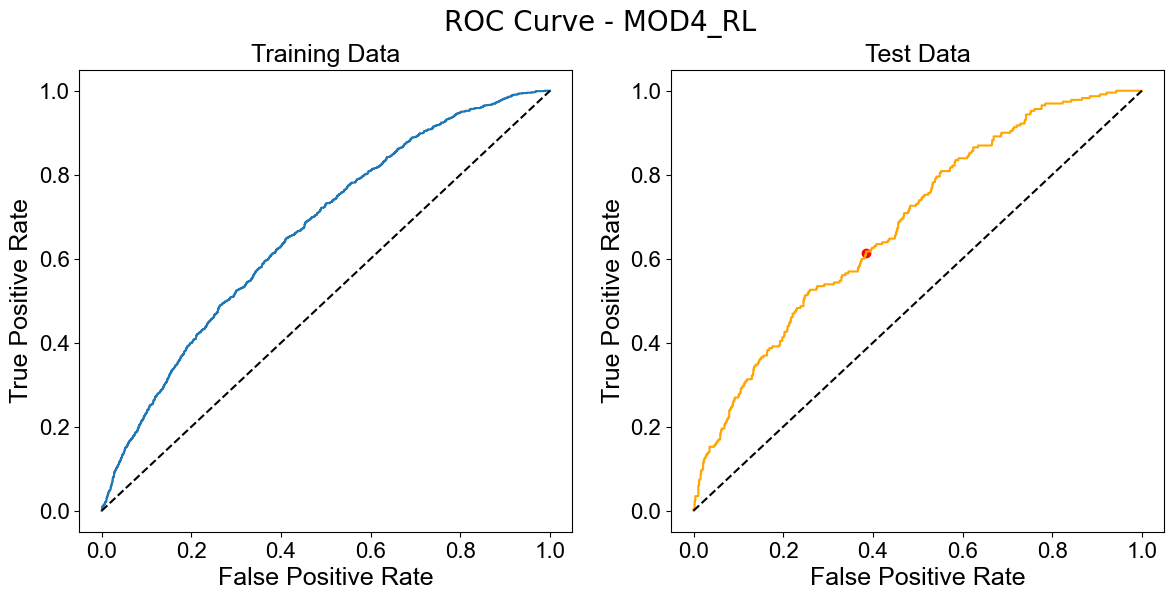

In [61]:
threshold = mod4_rl_test_roc.threshold[np.argmin(np.abs(mod4_rl_test_roc.fpr + mod4_rl_test_roc.tpr - 1))]
fpr, tpr = mod4_rl_test_roc.loc[mod4_rl_test_roc.threshold == threshold, :].values[:, :2][0]
print("threshold: ", threshold)
roc_plot(mod4_rl_train_roc, mod4_rl_test_roc, x_thres=fpr, y_thres=tpr, fig_title='MOD4_RL')

threshold:  0.8931466239541553
F-Score:  0.7816494845360826
Precision:  0.1905982905982906
Recall:  0.9695652173913044


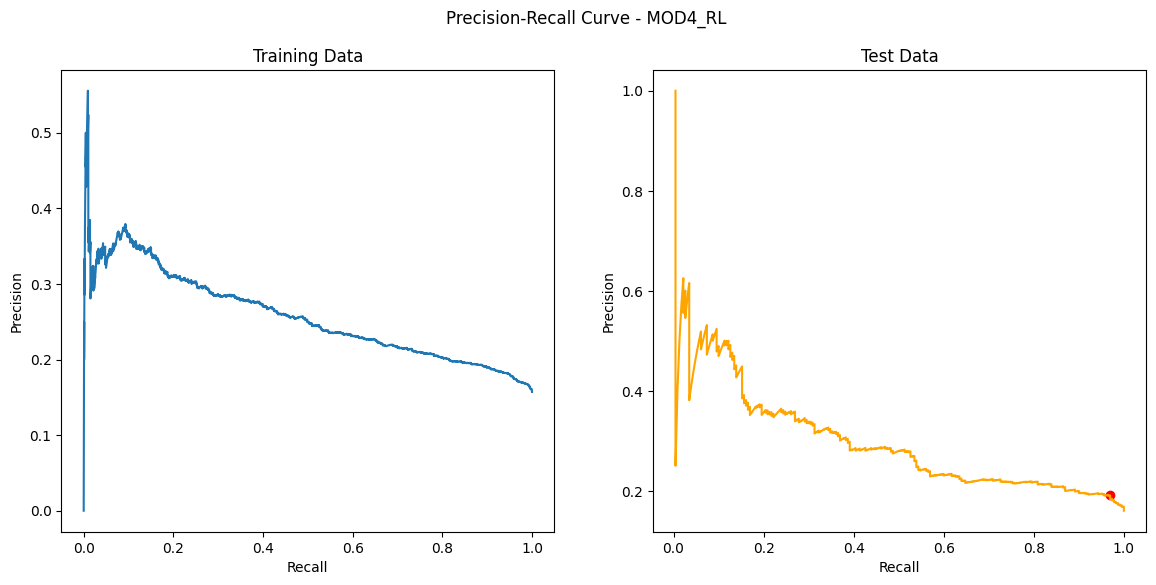

In [62]:
beta = 4
f2_score = ((1 + beta**2) * mod4_rl_test_prec_rec.precision * mod4_rl_test_prec_rec.recall) / (beta**2 * mod4_rl_test_prec_rec.precision + mod4_rl_test_prec_rec.recall)
index = np.argmax(f2_score)
opt_thres = mod4_rl_test_prec_rec.threshold[index]
opt_f2 = f2_score[index]
opt_prec = mod4_rl_test_prec_rec.precision[index]
opt_rec = mod4_rl_test_prec_rec.recall[index]

print("threshold: ", opt_thres)
print("F-Score: ", opt_f2)
print("Precision: ", opt_prec)
print("Recall: ", opt_rec)

precision_recall_plot(mod4_rl_train_prec_rec, mod4_rl_test_prec_rec, x_thres=opt_rec, y_thres=opt_prec, fig_title='MOD4_RL')

Beta:  10.0
threshold:  0.8931466239541553
F-Score:  0.7816494845360826
Precision:  0.1905982905982906
Recall:  0.9695652173913044


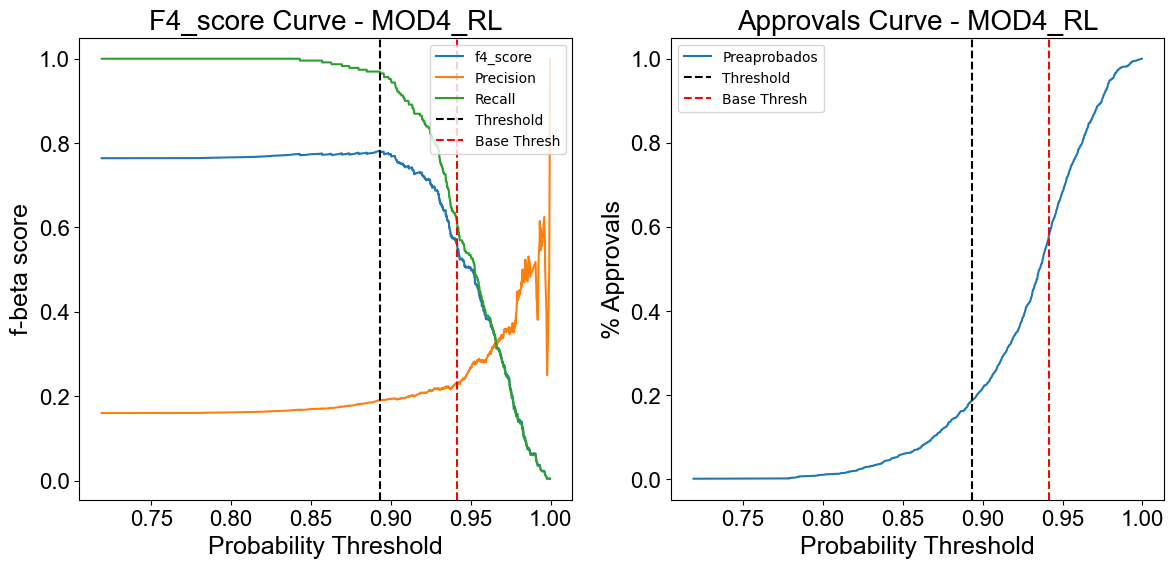

In [88]:
_ , _, x_thres = mod4_rl_test_roc.loc[mod4_rl_test_roc.threshold == mod4_rl_test_roc.threshold[np.argmin(np.abs(mod4_rl_test_roc.fpr + mod4_rl_test_roc.tpr - 1))], :].values[0]
fscore_approve_plot(mod4_rl_test_prec_rec, mod4_rl_test_pred, beta=4, base_thres=x_thres, alt_thres=None, fig_title='MOD4_RL')

### XGBoost

In [45]:
mod8_xgb_train_pred = pd.read_csv(f'{FILE_PATH}/train/predictions/MOD_8_XGB.csv', sep=',')
mod8_xgb_test_pred = pd.read_csv(f'{FILE_PATH}/test/predictions/MOD_8_XGB.csv', sep=',')

mod8_xgb_train_roc = pd.read_csv(f'{FILE_PATH}/train/roc/ROC_MOD_8_XGB.csv', sep=',')
mod8_xgb_test_roc = pd.read_csv(f'{FILE_PATH}/test/roc/ROC_MOD_8_XGB.csv', sep=',')

mod8_xgb_train_prec_rec = pd.read_csv(f'{FILE_PATH}/train/roc/PREC_REC_MOD_8_XGB.csv', sep=',')
mod8_xgb_test_prec_rec = pd.read_csv(f'{FILE_PATH}/test/roc/PREC_REC_MOD_8_XGB.csv', sep=',')

threshold:  0.85104173


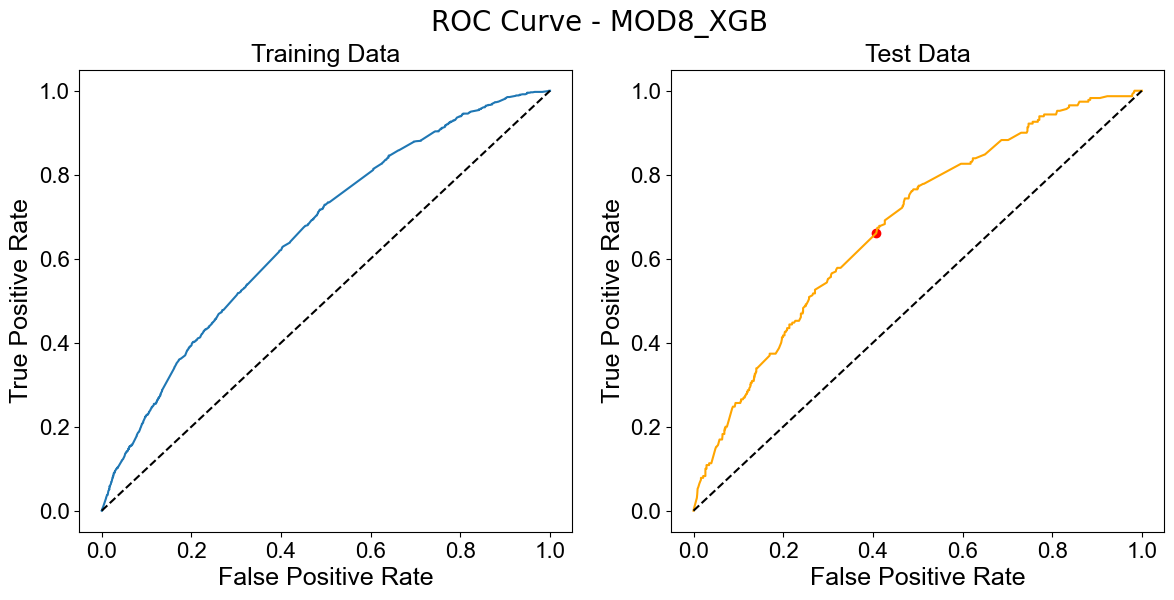

In [51]:
threshold = mod8_xgb_test_roc.threshold[np.argmin(np.abs(mod8_xgb_test_roc.fpr + mod8_xgb_test_roc.tpr - 1))]
fpr, tpr = mod8_xgb_test_roc.loc[mod8_xgb_test_roc.threshold == threshold, :].values[:, :2][0]
print("threshold: ", threshold)
roc_plot(mod8_xgb_train_roc, mod8_xgb_test_roc, x_thres=fpr, y_thres=tpr, fig_title='MOD8_XGB')

threshold:  0.8503717
F-Score:  0.7724165661439485
Precision:  0.1746522411128284
Recall:  0.982608695652174


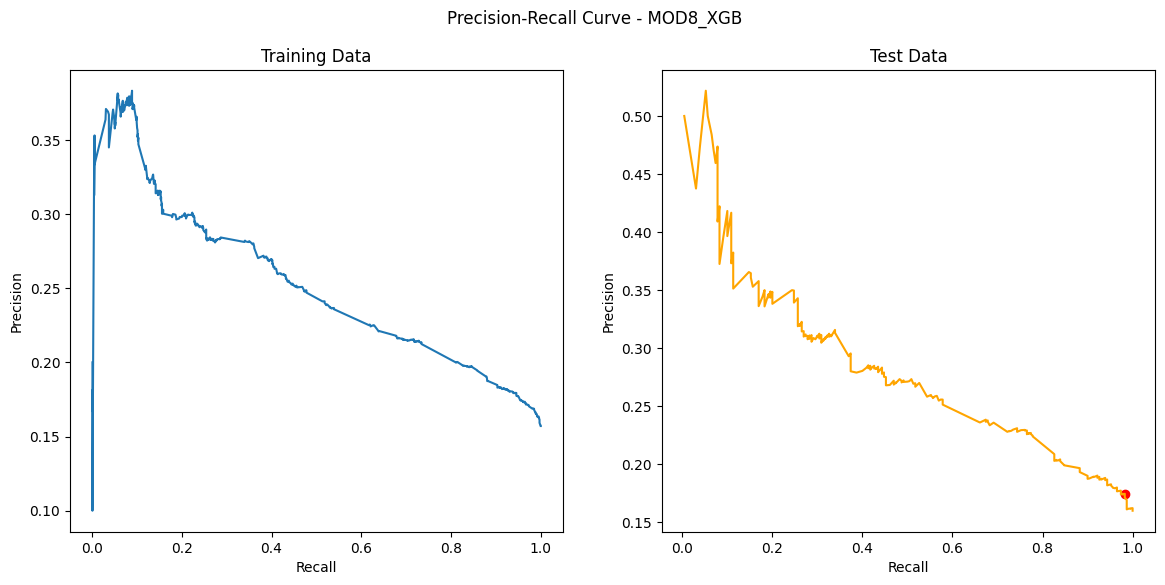

In [50]:
beta = 4
f2_score = ((1 + beta**2) * mod8_xgb_test_prec_rec.precision * mod8_xgb_test_prec_rec.recall) / (beta**2 * mod8_xgb_test_prec_rec.precision + mod8_xgb_test_prec_rec.recall)
index = np.argmax(f2_score)
opt_thres = mod8_xgb_test_prec_rec.threshold[index]
opt_f2 = f2_score[index]
opt_prec = mod8_xgb_test_prec_rec.precision[index]
opt_rec = mod8_xgb_test_prec_rec.recall[index]

print("threshold: ", opt_thres)
print("F-Score: ", opt_f2)
print("Precision: ", opt_prec)
print("Recall: ", opt_rec)

precision_recall_plot(mod8_xgb_train_prec_rec, mod8_xgb_test_prec_rec, x_thres=opt_rec, y_thres=opt_prec, fig_title='MOD8_XGB')

threshold:  0.8503717
F-Score:  0.7724165661439485
Precision:  0.1746522411128284
Recall:  0.982608695652174


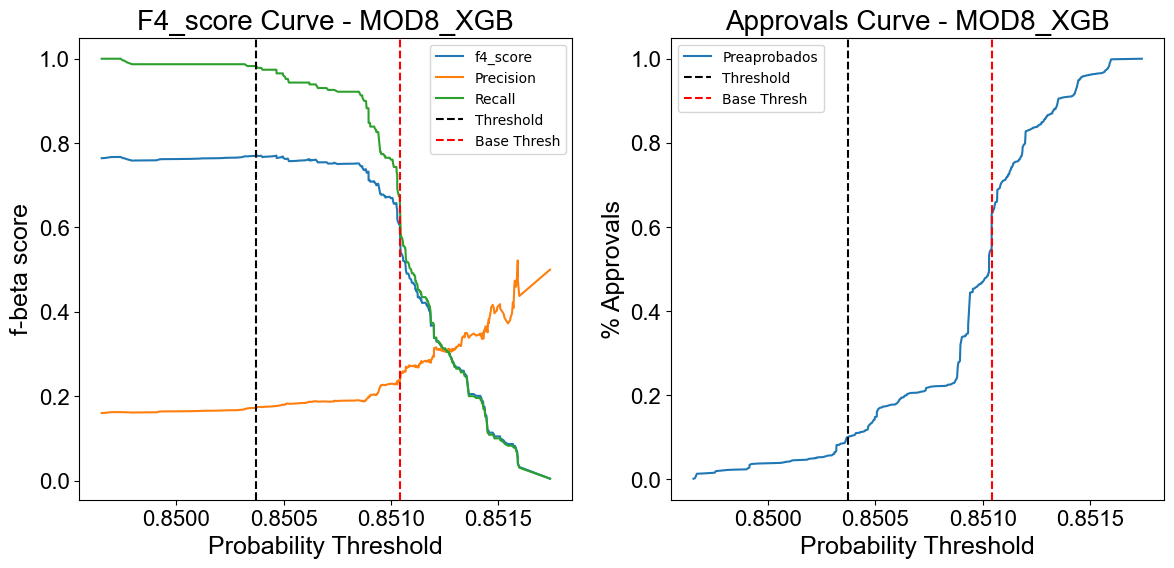

In [89]:
_ , _, x_thres = mod8_xgb_test_roc.loc[mod8_xgb_test_roc.threshold == mod8_xgb_test_roc.threshold[np.argmin(np.abs(mod8_xgb_test_roc.fpr + mod8_xgb_test_roc.tpr - 1))], :].values[0]
fscore_approve_plot(mod8_xgb_test_prec_rec, mod8_xgb_test_pred, beta=4, base_thres=x_thres, alt_thres=None, fig_title='MOD8_XGB')

## Random Forest

In [102]:
mod11_rf_train_pred = pd.read_csv(f'{FILE_PATH}/train/predictions/MOD_11_RF.csv', sep=',')
mod11_rf_test_pred = pd.read_csv(f'{FILE_PATH}/test/predictions/MOD_11_RF.csv', sep=',')

mod11_rf_train_roc = pd.read_csv(f'{FILE_PATH}/train/roc/ROC_MOD_11_RF.csv', sep=',')
mod11_rf_test_roc = pd.read_csv(f'{FILE_PATH}/test/roc/ROC_MOD_11_RF.csv', sep=',')

mod11_rf_train_prec_rec = pd.read_csv(f'{FILE_PATH}/train/roc/PREC_REC_MOD_11_RF.csv', sep=',')
mod11_rf_test_prec_rec = pd.read_csv(f'{FILE_PATH}/test/roc/PREC_REC_MOD_11_RF.csv', sep=',')

threshold:  0.9550156700915294


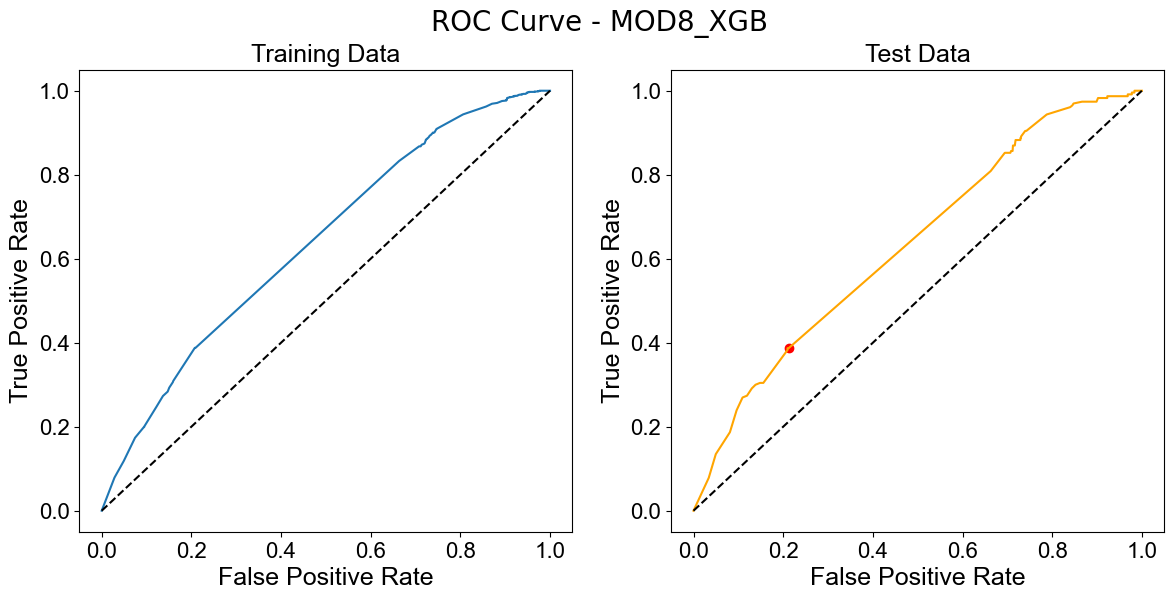

In [103]:
threshold = mod11_rf_test_roc.threshold[np.argmin(np.abs(mod11_rf_test_roc.fpr + mod11_rf_test_roc.tpr - 1))]
fpr, tpr = mod11_rf_test_roc.loc[mod11_rf_test_roc.threshold == threshold, :].values[:, :2][0]
print("threshold: ", threshold)
roc_plot(mod11_rf_train_roc, mod11_rf_test_roc, x_thres=fpr, y_thres=tpr, fig_title='MOD8_XGB')

threshold:  0.920715811606211
F-Score:  0.7695899309784815
Precision:  0.1789727126805778
Recall:  0.9695652173913044


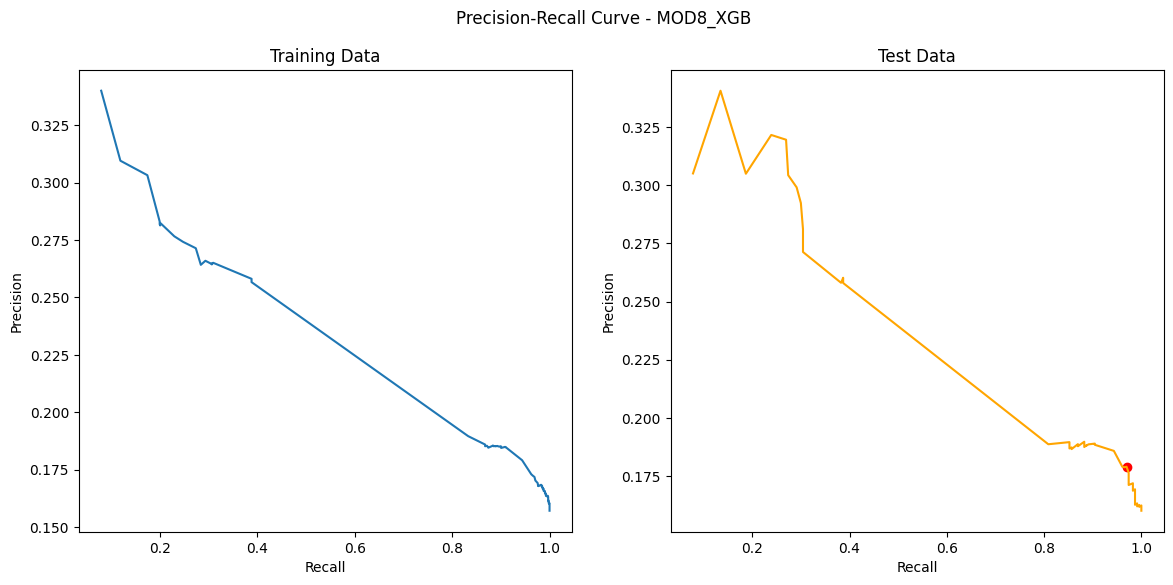

In [104]:
beta = 4
f2_score = ((1 + beta**2) * mod11_rf_test_prec_rec.precision * mod11_rf_test_prec_rec.recall) / (beta**2 * mod11_rf_test_prec_rec.precision + mod11_rf_test_prec_rec.recall)
index = np.argmax(f2_score)
opt_thres = mod11_rf_test_prec_rec.threshold[index]
opt_f2 = f2_score[index]
opt_prec = mod11_rf_test_prec_rec.precision[index]
opt_rec = mod11_rf_test_prec_rec.recall[index]

print("threshold: ", opt_thres)
print("F-Score: ", opt_f2)
print("Precision: ", opt_prec)
print("Recall: ", opt_rec)

precision_recall_plot(mod11_rf_train_prec_rec, mod11_rf_test_prec_rec, x_thres=opt_rec, y_thres=opt_prec, fig_title='MOD8_XGB')

## Confusion Matrix

In [105]:
models = {
    'MOD4_RL':[mod4_rl_test_prec_rec, mod4_rl_test_pred, mod4_rl_test_roc],
    'MOD8_XGB':[mod8_xgb_test_prec_rec, mod8_xgb_test_pred, mod8_xgb_test_roc],
    'MOD11_RF':[mod11_rf_test_prec_rec, mod11_rf_test_pred, mod11_rf_test_roc]
}

In [106]:
use_base_thresh = False
beta = 4
cols = ['Model', 'Threshold', f'F{beta}-Score', 'Recall',	'Precision',
        'Specificity', 'Roc-Auc', 'KS',	'GINI',	'TN', 'FP',	'FN', 'TP',	
        'Act_good', 'Act_bad', 'Total', 'Pred_good', 'Pred_bad',
        'Approval']
models_resume = pd.DataFrame(columns=cols)
for key, values in models.items():
    f_score = ((1 + beta**2) * values[0].precision * values[0].recall) / (beta**2 * values[0].precision + values[0].recall)
    index = np.argmax(f_score)
    
    if use_base_thresh:
        opt_thres = values[2].threshold[np.argmin(np.abs(values[2].fpr + values[2].tpr - 1))]
    else:
        opt_thres = values[0].threshold[index]

    y_test = values[1].actual_bad.values
    model_preds = proba_to_predictions(values[1], threshold=opt_thres)
    df = metrics_report(y_test=y_test, predictions=model_preds, beta=beta, threshold=opt_thres, model_name=key)
    
    models_resume = pd.concat([models_resume, df], axis=0, ignore_index=True)

models_resume = models_resume.reset_index(drop=True)

"""
     A1 |  A0
---------------
P1|  TP | FP
---------------
P0|  FN | TN

"""

(
models_resume
.style
.background_gradient(subset=['Recall', 'Precision', 'Roc-Auc', 'KS', f'F{beta}-Score', 'TN', 'FN', 'FP', 'TP', 'Approval', 'Pred_bad'], cmap='viridis')
.hide(axis='index')
 )

Model,Threshold,F4-Score,Recall,Precision,Specificity,Roc-Auc,KS,GINI,TN,FP,FN,TP,Act_good,Act_bad,Total,Pred_good,Pred_bad,Approval
MOD4_RL,0.893147,0.778305,0.965217,0.189906,0.539419,0.590314,0.180627,0.180627,260,947,8,222,1207,230,1437,268,1169,0.186500
MOD8_XGB,0.850372,0.769153,0.978261,0.174014,0.381868,0.546711,0.093422,0.093422,139,1068,5,225,1207,230,1437,144,1293,0.100209
MOD11_RF,0.920716,0.766761,0.965217,0.178744,0.457213,0.560073,0.120147,0.120147,187,1020,8,222,1207,230,1437,195,1242,0.135699
